In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
request_df = pd.read_csv("../2023requests.csv")

/var/folders/08/jl8s46nj1937wqfyst1xgq080000gn/T/ipykernel_8016/2648032890.py:1: DtypeWarning: Columns (8,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv("../2023requests.csv")


In [3]:
requestdf = request_df.copy()
pd.set_option("display.max_rows", 200)

Removes un-needed columns, with explanation why each was removed. Some may be useful for other analysis objectives.

In [7]:
#List of un-needed columns to drop to improve speed on current project
dropcolumns = ["Location Type", #specifies exact type of location, not used since only using lat-long
               "Incident Zip", "Incident Address", "Street Name", "Cross Street 1", "Cross Street 2", "Intersection Street 1", "Intersection Street 2", "Address Type", "City", #lat-long used instead of all up to Facility Type
               "Landmark", #closest landmark, not needed
               "Facility Type", #only DSNY Garage non-na, not needed
               "Due Date", #may be helpful for other analysis but not here
               "Resolution Description", #USEFUL FOR TEXT ANALYSIS IF USING
               "Resolution Action Updated Date", #not super relevant, also confusing without info into operations
               "BBL", #mostly missing, also replaced by lat-long
               "X Coordinate (State Plane)", "Y Coordinate (State Plane)", #not sure of use, also likely replaced by lat-long
               "Open Data Channel Type", #MAY BE NEAT FOR VIZUALING, medium of request
               "Park Facility Name", "Park Borough", #not needed due to lat-long
               "Vehicle Type", #may be useful if going in depth on vehicle requests
               "Taxi Company Borough", "Taxi Pick Up Location", #not needed
               "Bridge Highway Name", "Road Ramp", "Bridge Highway Segment", "Bridge Highway Direction", #not needed unless super specific wanted
               "Location", #lat-long combined,
               "Borough Boundaries", #just numerical of borough 1-5,
               "Police Precincts", #duplicate info of police precinct
               "Community Districts" #duplicate info of community board
               ]

requestdf = requestdf.drop(columns=dropcolumns)

Removing requests with no location data, mostly information requests which could be used outside of creating the map if necessary.

In [ ]:
print(requestdf["Longitude"].isna().sum(),requestdf["Latitude"].isna().sum())
print(requestdf.shape[0])
requestdf = requestdf.drop(index=requestdf.loc[requestdf["Longitude"].isna()].index)
print(requestdf.shape[0])

Removing requests with unspecified community boards due to difficulty joining with community board dataset and null data. 

In [ ]:
unspecifiedboard = requestdf.loc[requestdf["Community Board"].str.startswith("Unspecified")]
print("out of", unspecifiedboard.shape[0], "requests with unspecified community boards,")
print(unspecifiedboard["Closed Date"].isna().sum(), "of them were unclosed. These unspecified requests will be dropped due to NA data and to help with community board clarity")
requestdf = requestdf.drop(index=unspecifiedboard.index)

In [8]:
requestdf.isna().sum()

Unique Key                     0
Created Date                   0
Closed Date               127209
Agency                         0
Agency Name                    0
Complaint Type                 0
Descriptor                 96765
Status                         0
Community Board                0
Borough                        0
Latitude                       0
Longitude                      0
Zip Codes                  12338
Community Districts          682
City Council Districts       682
Police Precinct              664
dtype: int64

In [9]:
#replaces duplicate complaints
requestdf["Complaint Type"] = requestdf["Complaint Type"].replace(["PLUMBING", "HEAT/HOT WATER", "OUTSIDE BUILDING", "DOOR/WINDOW", "ELECTRIC", "GENERAL", "PAINT/PLASTER", "Peeling Paint", "UNSANITARY CONDITION", "FLOORING/STAIRS", "WATER LEAK", "SAFETY", "APPLIANCE", "ELEVATOR"],
                                                                  ["Plumbing", "Heat/Hot Water", "Outside Building", "Door/Window", "Electric", "General", "Paint/Plaster", "Paint/Plaster", "Unsanitary Condition", "Flooring/Stairs", "Water Leak", "Safety", "Appliance", "Elevator"])
requestdf["Complaint Type"] = requestdf["Complaint Type"].replace(["Mold", "Special Projects Inspection Team (SPIT)"],
                                                                  ["Unsanitary Condition", "Building Code Violation"])

makes a copy of all requests before narrowing down data to only the top 50 complaints

In [10]:
allrequesttypes = requestdf.copy()
requestdf = requestdf.loc[requestdf["Complaint Type"].isin(requestdf["Complaint Type"].value_counts().head(50).index)].copy()

Assigns categories to complaint types, to help users navigate the map filters easier.

In [12]:
requestdf["Complaint Type"].unique()
#assigning each of the top 50 complaints to a category, Adapted from categories used at https://portal.311.nyc.gov/report-problems/
categories = {'Noise - Street/Sidewalk':'Noise', 'Noise - Helicopter':'Noise',
            'Blocked Driveway':'Transportation', 'Illegal Parking':'Transportation', 'Noise - Residential':'Noise',
            'Heat/Hot Water':'Utilities', 'Noise - Commercial':'Noise', 'Sidewalk Condition':'Sidewalks, Streets & Highways',
            'Abandoned Vehicle':'Transportation', 'New Tree Request':'Environment', 'Door/Window':'Housing & Buildings', 'Electric':'Utilities',
            'Water System':'Utilities', 'Sewer':'Utilities', 'Plumbing':'Utilities', 'Non-Emergency Police Matter':'Public Safety',
            'Noise - Vehicle':'Noise', 'Noise':'Noise', 'Consumer Complaint':'Businesses & Consumers',
            'Traffic Signal Condition':'Sidewalks, Streets & Highways', 'Building/Use':'Housing & Buildings', 'General':'Misc',
            'Dirty Condition':'Trash & Recycling', 'Rodent':'Health', 'Obstruction':'Sidewalks, Streets & Highways', 'Illegal Dumping':'Public Safety',
            'Paint/Plaster':'Housing & Buildings', 'Unsanitary Condition':'Health', 'Flooring/Stairs':'Housing & Buildings',
            'General Construction/Plumbing':'Housing & Buildings', 'Street Light Condition':'Sidewalks, Streets & Highways',
            'Food Establishment':'Businesses & Consumers', 'Water Leak':'Utilities', 'Damaged Tree':'Environment', 'Safety':'Health',
            'Missed Collection':'Trash & Recycling', 'Street Condition':'Sidewalks, Streets & Highways', 'Vendor Enforcement':'Businesses & Consumers',
            'Graffiti':'Misc', 'Elevator':'Housing & Buildings', 'Residential Disposal Complaint':'Trash & Recycling',
            'Drug Activity':'Public Safety', 'Appliance':'Housing & Buildings', 'Air Quality':'Environment', 'Encampment':'Misc',
            'For Hire Vehicle Complaint':'Misc', 'Overgrown Tree/Branches':'Environment',
            'Maintenance or Facility':'Housing & Buildings', 'Homeless Person Assistance':'Misc',
            'Derelict Vehicles':'Transportation'}
requestdf["Complaint Category"] = requestdf["Complaint Type"].map(categories)
#all unique categories
requestdf["Complaint Category"].unique()

In [14]:
requestdf.head(5)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Status,Community Board,Borough,Latitude,Longitude,Zip Codes,Community Districts,City Council Districts,Police Precinct,Complaint Category
4,59889383,12/31/2023 11:59:42 PM,01/01/2024 01:51:01 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Closed,06 QUEENS,QUEENS,40.734695,-73.850521,14786.0,40.0,28.0,70.0,Noise
5,59887573,12/31/2023 11:59:39 PM,01/19/2024 02:37:37 PM,EDC,Economic Development Corporation,Noise - Helicopter,Other,Closed,07 MANHATTAN,MANHATTAN,40.777201,-73.976159,12420.0,20.0,19.0,12.0,Noise
6,59892892,12/31/2023 11:59:29 PM,01/01/2024 04:06:24 AM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Closed,07 QUEENS,QUEENS,40.759286,-73.822614,14190.0,22.0,3.0,67.0,Transportation
7,59893860,12/31/2023 11:59:29 PM,01/01/2024 01:51:32 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Closed,06 QUEENS,QUEENS,40.729379,-73.855433,14785.0,40.0,28.0,70.0,Noise
8,59887231,12/31/2023 11:59:23 PM,01/01/2024 12:13:30 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Closed,12 BROOKLYN,BROOKLYN,40.644725,-73.997622,13515.0,2.0,7.0,39.0,Noise


Lots of entries with missing closing date, below is a graph of the most commonly unclosed requests.

Text(0.5, 1.0, 'Top 10 Unclosed Complaints')

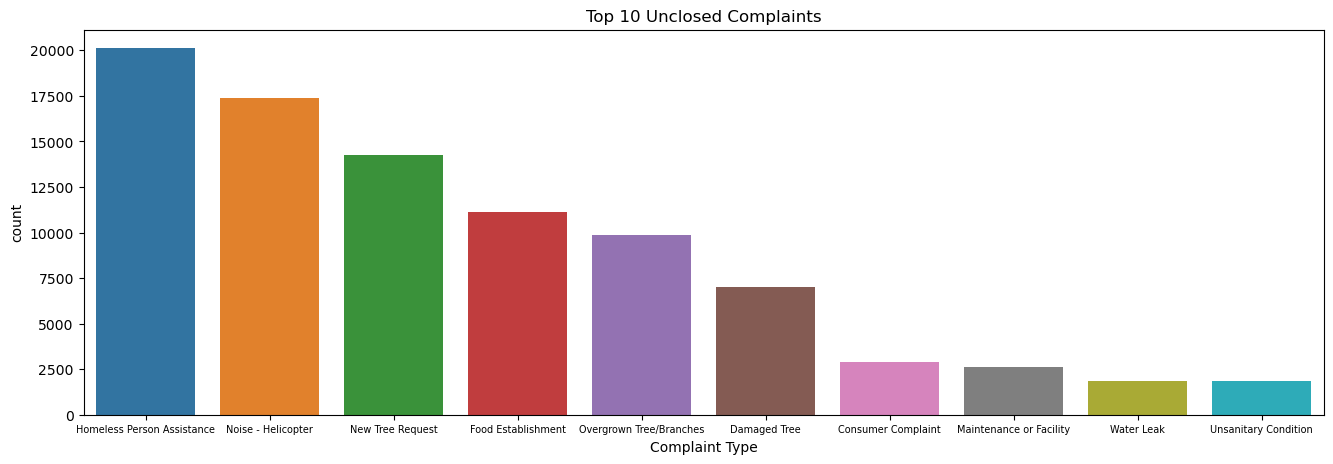

In [15]:
notclosed = requestdf.loc[requestdf["Closed Date"].isna()]
plt.figure(figsize=(16,5))
sns.countplot(data=notclosed, x="Complaint Type", order=notclosed["Complaint Type"].value_counts().iloc[:10].index)
plt.xticks(fontsize=7, rotation=0)
plt.title("Top 10 Unclosed Complaints")

Non-closed requests for things besides actionable items may be due to a request not needing resolution like **Noise-Helicopter**. These requests will still be included in overall count since they are requests despite not being closed, and will just not have a time to resolve when calculated.

In [17]:
#converts dates from str into datetime format
requestdf["Created Date"] = pd.to_datetime(requestdf["Created Date"], format="%m/%d/%Y %I:%M:%S %p")
requestdf["Closed Date"] = pd.to_datetime(requestdf["Closed Date"], format="%m/%d/%Y %I:%M:%S %p")

In [18]:
#creates requesttime as timedelta of time from request open to close
requestdf["Request Time"] = requestdf["Closed Date"] - requestdf["Created Date"]
#creates new columns of hours and minutes integers from timedelta
requestdf["Request Hours"] = requestdf["Request Time"].dt.total_seconds() // 3600
requestdf["Request Minutes"] = (requestdf["Request Time"].dt.total_seconds() % 3600) // 60
#null values still exist, leave for now to not effect average

In [26]:
#lists complaint types with the longest median(instead of mean due to outliers) times to close.
requestdf[["Complaint Type", "Request Time"]].groupby(by="Complaint Type").median().sort_values(by="Request Time", ascending=False).head(5)

,Request Time
Complaint Type,
For Hire Vehicle Complaint,63 days 04:51:42.500000
Building/Use,42 days 09:55:27
Elevator,32 days 11:14:19
Noise - Helicopter,28 days 13:32:33.500000
Graffiti,18 days 07:26:15


Some categories have extreme outliers, and may influence mean which is why median is used. If necessary, more data cleaning could be done using domain knowledge to remove accidentally unlosed complaints while keeping actual outliers.

In [31]:
requestdf.loc[requestdf["Request Hours"] > 10000]["Complaint Type"].value_counts()

Complaint Type
New Tree Request                 36
Maintenance or Facility          30
Street Light Condition           21
General Construction/Plumbing    15
Damaged Tree                     10
Traffic Signal Condition          7
Overgrown Tree/Branches           5
Building/Use                      4
Sewer                             3
Graffiti                          3
Illegal Dumping                   2
Unsanitary Condition              2
General                           1
Water Leak                        1
Flooring/Stairs                   1
Door/Window                       1
Appliance                         1
Name: count, dtype: int64

Text(0.5, 1.0, '# of Common Complaints Resolved Under 10 Minutes, by Type')

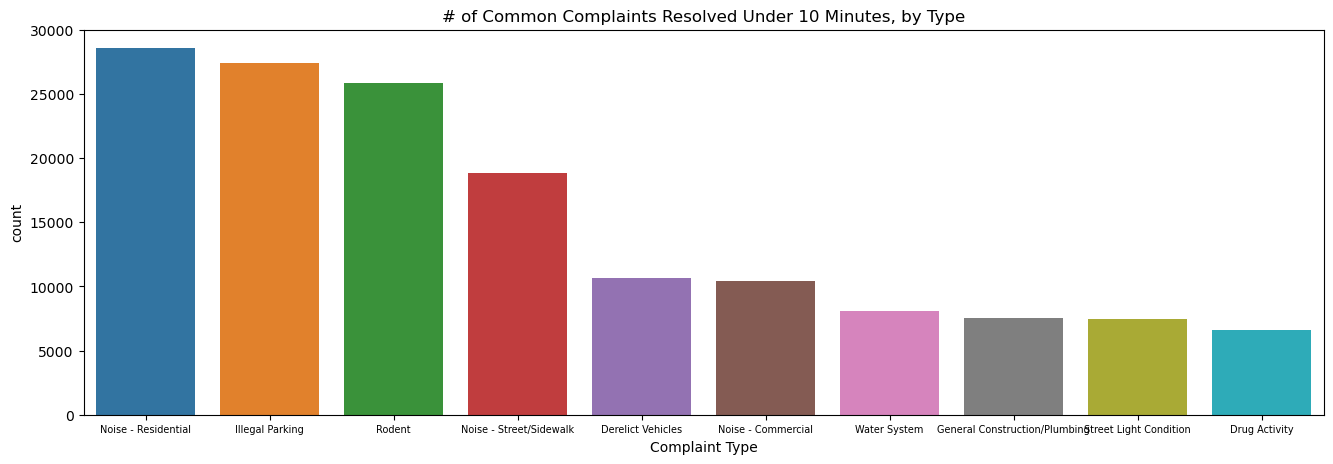

In [50]:
quickresolve = requestdf.loc[(requestdf["Request Hours"] == 0) & (requestdf["Request Minutes"] < 10)]
plt.figure(figsize=(16,5))
sns.countplot(data=quickresolve, x="Complaint Type", order=quickresolve["Complaint Type"].value_counts().iloc[:10].index)
plt.xticks(fontsize=7, rotation=0)
plt.title("# of Common Complaints Resolved Under 10 Minutes, by Type")

commented out saving dataframe as csv to avoid repeat saving

In [51]:
# requestdf.to_csv("../organizedrequests.csv")

In [78]:
requestdf.loc[requestdf["Community Board"] == "83 QUEENS"]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Status,Community Board,Borough,Latitude,Longitude,Zip Codes,Community Districts,City Council Districts,Police Precinct,Complaint Category,Request Time,Request Hours,Request Minutes
33680,59861492,2023-12-27 13:32:08,2024-02-22 14:47:33,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Passenger,Closed,83 QUEENS,QUEENS,40.648320,-73.788281,24339.0,64.0,46.0,71.0,Misc,57 days 01:15:25,1369.0,15.0
46720,59839923,2023-12-25 19:17:09,2024-01-05 08:57:34,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Car Service Company Complaint,Closed,83 QUEENS,QUEENS,40.648320,-73.788281,24339.0,64.0,46.0,71.0,Misc,10 days 13:40:25,253.0,40.0
67098,59817947,2023-12-22 17:23:59,NaT,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Car Service Company Complaint,In Progress,83 QUEENS,QUEENS,40.648320,-73.788281,24339.0,64.0,46.0,71.0,Misc,NaT,NaN,NaN
77802,59808165,2023-12-21 14:15:56,NaT,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Passenger,In Progress,83 QUEENS,QUEENS,40.648320,-73.788281,24339.0,64.0,46.0,71.0,Misc,NaT,NaN,NaN
86618,59796588,2023-12-20 15:14:13,2024-01-04 10:25:20,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Non Passenger,Closed,83 QUEENS,QUEENS,40.648320,-73.788281,24339.0,64.0,46.0,71.0,Misc,14 days 19:11:07,355.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195895,56438393,2023-01-04 22:59:42,2023-03-13 09:56:38,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Car Service Company Complaint,Closed,83 QUEENS,QUEENS,40.648320,-73.788281,24339.0,64.0,46.0,71.0,Misc,67 days 10:56:56,1618.0,56.0
3198639,56443741,2023-01-04 15:27:46,2023-01-05 10:33:49,DCA,Department of Consumer Affairs,Consumer Complaint,Other,Closed,83 QUEENS,QUEENS,40.644782,-73.794245,24339.0,64.0,46.0,71.0,Businesses & Consumers,0 days 19:06:03,19.0,6.0
3205461,56430012,2023-01-03 19:29:31,2023-05-30 14:06:01,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Passenger,Closed,83 QUEENS,QUEENS,40.648320,-73.788281,24339.0,64.0,46.0,71.0,Misc,146 days 18:36:30,3522.0,36.0
3207787,56427831,2023-01-03 13:47:07,2023-05-30 13:30:45,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Passenger,Closed,83 QUEENS,QUEENS,40.648320,-73.788281,24339.0,64.0,46.0,71.0,Misc,146 days 23:43:38,3527.0,43.0
